In [120]:
#!/usr/bin/env python
# coding=utf-8

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import statsmodels
import seaborn as sns
sns.set(color_codes=True)

current_palette = sns.color_palette()
first = current_palette[0]
second = current_palette[1]
sns.set_palette(
    [second, first] + current_palette[2:]
)

from scipy import stats
from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    #fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [121]:
DIR = '../../data/data_evaluation_3MONTHS_filtered'
CDIR = '../../data/data_evaluation_3MONTHS_filtered/charts'

db = YTDatabase()

In [122]:
# read data from channel statistics notebook
df_channel = pa.read_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')

In [123]:
# read data from collaboration notebook
#df_graph = pa.read_csv(DIR+r'/df_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)
df_graph_filtered = pa.read_csv(DIR+r'/df_filtered_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)


df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.loads)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.loads)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.loads)

#print len(df_graph)
print len(df_graph_filtered)


df_graph_filtered.head()

1728


,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
0,4806,UCw-hc7ZJummS0AvWyjUX56A,Sports,"[3102, 4806, 12796]",None,3,Fitness,UCWYtZYH4kcbMm29liIOSGQQ,Sports,"[2996, 3143, 5232, 7762]",BroadbandTV,3,Sports,[Q-Z7QYkqn2M],1
1,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[5556, 5884, 7050]",Maker Studios,2,Football,UCIKF1msqN7lW9gplsifOPkQ,Entertainment,[12627],BroadbandTV,3,Music,[On4GE5hAU8s],1
2,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[5556, 5884, 7050]",Maker Studios,2,Football,UC3M4u8_WwqY-2xDbJXxo5eQ,Gaming,"[4139, 7049]",OmniaMediaCo,3,Sports game,[4cEkXTIcvH4],1
3,6135,UCMDz09-3zO1hm1pqRA-Er0A,Entertainment,[6135],BroadbandTV,3,Lifestyle,UC3fxB7rF6T7wqymKUJxwmXA,Entertainment,,BroadbandTV,3,Lifestyle,[C7Waq5ZgqGU],1
4,1367,UCUcBFGAfOzut1x4GSWa6Akg,Entertainment,"[1367, 4731, 5365, 6760]",Maker Studios,3,Music,UCCk_JV7ar8HlxWZRXQKgS7w,People & Blogs,,BroadbandTV,2,Lifestyle,[RJir4ghyTDo],1


In [124]:
# Number of actual collab videos
videos = []
for i, row in df_graph_filtered.iterrows():
    videos.extend(row['videos'])
    
print len(videos)

3925


In [6]:
# get history statistscs from db of videos

with db._session_scope(False) as session:

    df_video_history = pa.read_sql(session.query(VideoHistory).statement, db.engine)

In [125]:
len(df_graph_filtered['to'].unique())

1114

In [10]:
df_video_history = df_video_history.set_index(['id'])

df_video_history['crawlTimestamp'] = df_video_history['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))

df_video_history.head()

,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp
id,,,,,,
1,qBZKeIbNDcE,9,0,1,0,2016-12-28 03:03:22
2,2A6NSm9aSVQ,139,5,14,2,2016-12-28 03:03:23
3,0hAym2XYn9w,60,3,9,0,2016-12-28 03:03:48
4,VGHx-lcdJps,258,21,64,2,2016-12-28 03:03:49
5,xYi6uCXmCFo,337,8,94,1,2016-12-28 03:03:52


In [12]:
# Video history grouping
video_groups = df_video_history.groupby(['videoID'])

print len(df_video_history), len(video_groups)

# filtering too young videos for half life study of 6 days
vcounts = video_groups['viewCount'].count()
mask = vcounts[vcounts > 11].index

df_video_history_filtered = df_video_history[df_video_history.videoID.isin(mask)]

video_groups_filtered = df_video_history_filtered.groupby(['videoID'])

print len(df_video_history_filtered), len(video_groups_filtered)


13035916 232879
12899364 207380


ISLuff63OlI


<IPython.core.display.Javascript object>


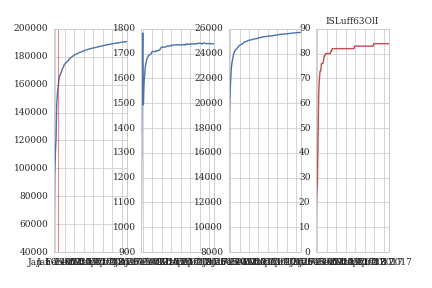

2017-01-08 00:07:01
2017-04-25 11:06:00
Age: 107
First 6 days made 0.745408929895 %


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [13]:
# video sample statistics

from sklearn import preprocessing

name = 'ISLuff63OlI'
group = video_groups.get_group(name)

print name
fig, axs = plt.subplots(ncols=4)
plt.title(name)
axs[0].plot_date(group['crawlTimestamp'], group['viewCount'], 'b-')
axs[0].axvline(group.iloc[0, 5] + timedelta(days=6), color='red', linewidth=.5)
axs[1].plot_date(group['crawlTimestamp'], group['commentCount'], 'b-')
axs[2].plot_date(group['crawlTimestamp'], group['likeCount'], 'b-')
axs[3].plot_date(group['crawlTimestamp'], group['dislikeCount'], 'r-')

    
print group['crawlTimestamp'].min()
print group['crawlTimestamp'].max()
print 'Age:', (group['crawlTimestamp'].max() - group['crawlTimestamp'].min()).days

# views percentage
# Create x, where x the scores columns values as floats
x = group['viewCount'].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
group['viewCount_norm'] = x_scaled

print 'First 6 days made', group[(group.crawlTimestamp <= group.iloc[0, 5] + timedelta(days=6))]['viewCount_norm'].max(), '%'

#group

zyRcHomiM5c


<IPython.core.display.Javascript object>


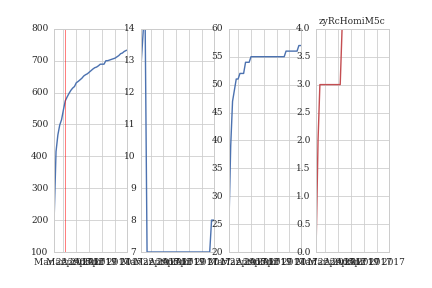

99_k3EC7sVM


<IPython.core.display.Javascript object>


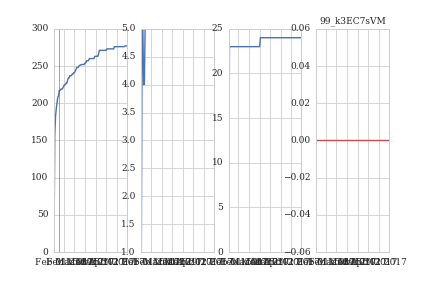

01RW7wZbT8U


<IPython.core.display.Javascript object>


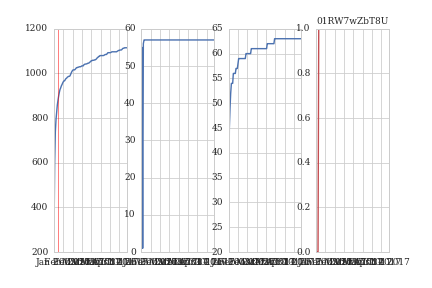

TmMZY5NUNGM


<IPython.core.display.Javascript object>


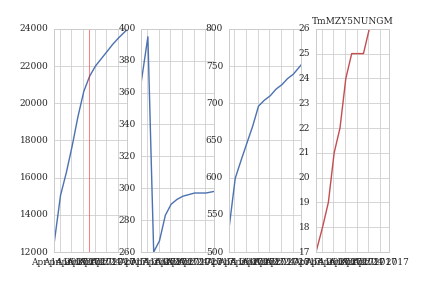

E57PBLnJjIA


<IPython.core.display.Javascript object>


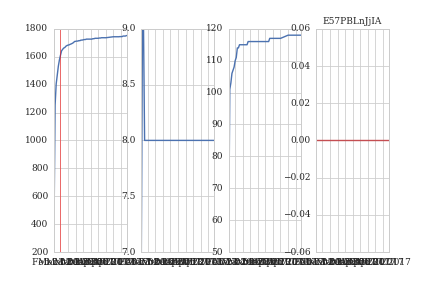

anT-y3Px4QM


<IPython.core.display.Javascript object>


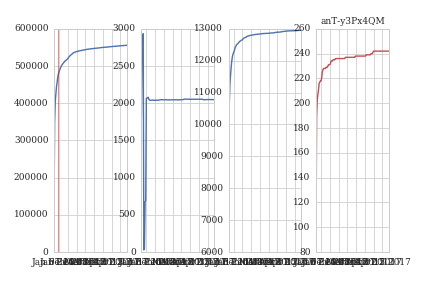

c6c33WN-pMs


<IPython.core.display.Javascript object>


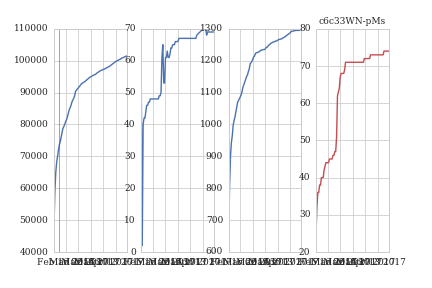

ThliEAOvVqc


<IPython.core.display.Javascript object>


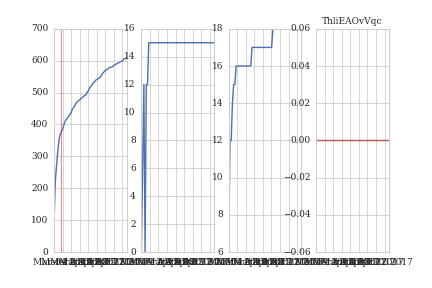

BCwGKfmGpXc


<IPython.core.display.Javascript object>


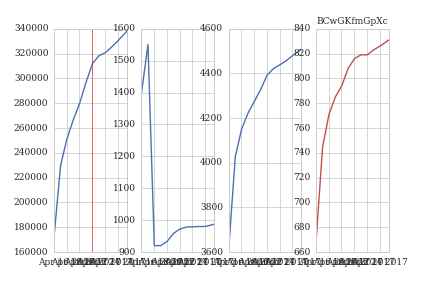

HHWf12L-JcM


<IPython.core.display.Javascript object>


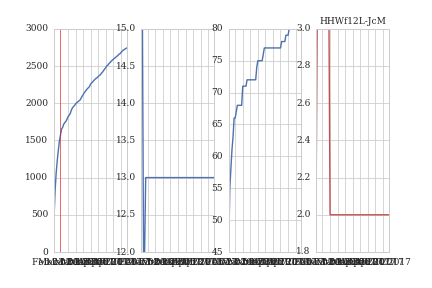

In [14]:
# multi sample channel statistics
import random


sampled_df_i  = random.sample(video_groups.indices, 10)
df_list  = map(lambda df_i: (df_i, video_groups.get_group(df_i)), sampled_df_i)


for name, group in df_list:
    print name
    fig, axs = plt.subplots(ncols=4)
    plt.title(name)
    axs[0].plot_date(group['crawlTimestamp'], group['viewCount'], 'b-')
    axs[0].axvline(group.iloc[0, 5] + timedelta(days=6), color='red', linewidth=.5)
    axs[1].plot_date(group['crawlTimestamp'], group['commentCount'], 'b-')
    axs[2].plot_date(group['crawlTimestamp'], group['likeCount'], 'b-')
    axs[3].plot_date(group['crawlTimestamp'], group['dislikeCount'], 'r-')


In [15]:
# difference between video stats of collab and non_collab videos of same channel
# are collab videos more popular than normal for channel?


In [16]:
# create boxplot per channel, collab noncollab videos compared
# comparing what?
# viewcount gradient?
# viewcount max, mean? -> max mean of collab, non_collab videos
# consider age of video? take only first 6 days into account

In [14]:
# age dist, for all videos

df_video_age = []

for name, group in video_groups:

    age = (group['crawlTimestamp'].max() - group['crawlTimestamp'].min()).days
    df_video_age.append((name, age))
    
df_video_age = pa.DataFrame(df_video_age, columns=['id', 'age'])

KeyboardInterrupt: 

0


<IPython.core.display.Javascript object>


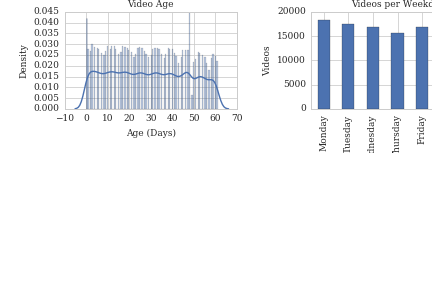

,id,age,date,dayn
0,--0s03JYIww,27,2017-01-24,Tuesday
1,--1lgNZ9cvY,14,2017-01-11,Wednesday
2,--4kDK_RBjg,48,2017-02-14,Tuesday
3,--4n0eZ8XTQ,1,2016-12-29,Thursday
4,--5mUkeFBmI,56,2017-02-22,Wednesday


In [118]:

df_video_age['date'] = df_video_age['age'].apply(lambda x: date(2016, 12, 28) + timedelta(days=x))
df_video_age['dayn'] = df_video_age['date'].apply(lambda x: x.strftime("%A"))

print df_video_age['age'].min()

#ax = df_video_age[['date']].groupby(df_video_age['date']).count().plot(kind='bar')
test = df_video_age[['dayn']].groupby(df_video_age['dayn']).count()
order = [u'Monday',u'Tuesday',u'Wednesday',u'Thursday',u'Friday',u'Saturday',u'Sunday']


fig, axs = plt.subplots(1, 2)

#fig, ax = plt.subplots()
ax = test.ix[order].plot(kind='bar',legend=False, ax=axs[1])
ax.set_xlabel('Weekday')
ax.set_ylabel('Videos')
fig.tight_layout()
axs[1].set_title('Videos per Weekday')
#save_plot('video_weekday_counts.pdf', fig, s_width, s_height)

#ax.set_xticks(ax.get_xticks()[::2])
#fig = plt.figure()
ax = sns.distplot(df_video_age['age'], bins=100, ax=axs[0])
ax.set_xlabel('Age (Days)')
ax.set_ylabel('Density')
fig.tight_layout()
axs[0].set_title('Video Age')

save_plot('video_age_and_days.pdf', fig, 2*s_width, s_height)
#ax.set_xticklabels(df_video_age['date'])
#age_groups = range(0, 70, 5)
#print age_groups
#for age in age_groups:
#    ax.axvline(age, color='red', linewidth=.5)



df_video_age.head()

In [126]:
# get all videos
with db._session_scope(False) as session:

    df_videos = pa.read_sql(session.query(Video).statement, db.engine)
    

df_videos = df_videos.set_index(['id'])

df_videos['dateAdded'] = df_videos['dateAdded'].apply(lambda x: datetime.strptime(x, date_format))
df_videos['crawlTimestamp'] = df_videos['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))


# filter videos only related to channel with collabs

df_videos_collabs = df_videos[ (df_videos.channelID.isin(df_graph_filtered['from'].tolist())) | (df_videos.channelID.isin(df_graph_filtered['to'].tolist()))]
df_videos_collabs_without_gaming = df_videos[ (df_videos.channelID.isin(df_graph_filtered['from'].tolist())) | (df_videos.channelID.isin(df_graph_filtered['to'].tolist()))]

#df_videos_collabs.head()

print 'All videos:', len(df_videos)
print 'Collab related videos:', len(df_videos_collabs)
print 'Actual collab videos:', len(videos)

df_videos_collabs.head()

All videos: 250420
Collab related videos: 81942
Actual collab videos: 3925


,channelID,title,description,category,dateAdded,tags,topicIds,attribution,duration,crawlTimestamp,deleted
id,,,,,,,,,,,
__3e1lrV5c8,UCajyfb5EUPd3f3deUk0dBEQ,NEUE DM ZAHNBÜRSTEN PINSEL im LIVE TEST | Mami...,Neu bei dm gibt es die gehypten Zahnbürsten Pi...,26,2017-02-19 11:30:00,"[""mamiseelen"",""dm zahnb\u00fcrsten pinsel"",""li...","[""/m/0yxzwny"",""/m/012xff""]",None,PT7M41S,2017-02-20 00:10:55,None
__3Pz5Hmm4c,UCw6Ou-fRcPa23GvYq-VHEbA,IS LONZO BALL'S $495 SIGNATURE SHOE THE ZO2 WO...,ENJOY AND LEAVE A LIKE!\nPodcast Link - https:...,26,2017-05-06 04:12:59,"[""lonzo"",""ball"",""zo2"",""lonzo ball sneaker"",""bi...",[],None,PT11M16S,2017-05-07 00:12:42,None
__6aGbnZHXQ,UCFdIIKy9ZQuIuRnpXLVabfQ,​Provando Doce de 1 Dolar - Dollar Tree ? Vit...,"​ ? Clique Gostei, Comente, INSCR...",22,2017-04-05 23:00:01,"[""vitoriademattia diario8765redfwhgy24"",""TAG V...",[],None,PT21M56S,2017-04-07 00:12:54,None
__9yzCbryRw,UCBkZWl8s1Cg22Yw11O6A-PQ,A Futile Effort!/Hope Incarnate! | Made By Son...,READ THIS :D\nI really Love this Song a lot. I...,23,2017-02-12 19:32:47,"[""Hip Hop"",""Sonic The Ghetto-Hog productions"",...","[""/m/08b26_""]",None,PT4M10S,2017-02-13 00:10:02,None
__a6tnmzoU4,UCxL7KXCV5YW0KdPRV583VJQ,NEW YEAR NEW BABY!?,WHATS IN MY BAG? → http://bit.ly/2iO7QLz\nWATC...,22,2017-01-13 20:00:30,"[""new year"",""new years"",""baby"",""pregnant"",""new...",[],None,PT7M32S,2017-01-14 00:13:27,None


In [127]:
with db._session_scope(False) as session:

    df_channel_history_collabs = pa.read_sql(session.query(ChannelHistory).filter((ChannelHistory.channelID.in_(df_graph_filtered['from'].tolist())) | (ChannelHistory.channelID.in_(df_graph_filtered['to'].tolist()))).statement, db.engine)

channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])

print len(df_channel_history_collabs), len(channel_collabs_groups)

191320 1599


In [261]:
print len(df_graph_filtered)

df_collab_channels = pa.Series([])

df_collab_channels = df_collab_channels.append(df_graph_filtered['to'])
df_collab_channels = df_collab_channels.append(df_graph_filtered['from'])

print len(df_collab_channels.unique())
df_collab_channels.head()

1728
1599


0    UCWYtZYH4kcbMm29liIOSGQQ
1    UCIKF1msqN7lW9gplsifOPkQ
2    UC3M4u8_WwqY-2xDbJXxo5eQ
3    UC3fxB7rF6T7wqymKUJxwmXA
4    UCCk_JV7ar8HlxWZRXQKgS7w
dtype: object

In [ ]:
# mark videos collab or non_collab
# create video collab list

df_videos_collabs['collab_window'] = 'Non_Collab'

for name, group in channel_collabs_groups:
    videos = []
    # own videos
    for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            df_videos_collabs.ix[vid, 'collab_window'] = 'Collab'

    # external videos (hes in)
    for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            df_videos_collabs.ix[vid, 'collab_window'] = 'Collab'
            
print len(df_videos_collabs)
df_videos_collabs.head()

In [133]:
# FIX read old collabs list, filter with new
# df_videos_collabs_without_gaming

df_videos_collabs = pa.read_csv(DIR+r'/df_video_collabs_stats.txt', sep=str('\t'), encoding='utf-8')
#df_videos_collabs=df_videos_collabs.set_index(['id'])
print len(df_videos_collabs)

print len(df_videos_collabs_without_gaming)
mask = df_videos_collabs_without_gaming.index

df_videos_collabs = df_videos_collabs[df_videos_collabs.id.isin(mask)]
df_videos_collabs=df_videos_collabs.set_index(['id'])
print len(df_videos_collabs)

167389
81942
81486


In [134]:
print len(df_videos_collabs)

print len(df_videos_collabs[df_videos_collabs.collab_window=='Collab'])

print len(df_videos_collabs[df_videos_collabs.collab_window=='Non_Collab'])
#df_videos_collabs.to_csv(DIR+r'/df_videos_collab.txt', sep=str('\t'), encoding='utf-8')

81486
4234
77252


In [ ]:
# calculate video view gradient like for channel, see if difference for collabs

#video_groups_filtered = df_video_history_filtered

print len(video_groups_filtered)
print len(df_videos_collabs)
mask = df_videos_collabs.index

df_video_history_collabs = df_video_history_filtered[df_video_history_filtered.videoID.isin(mask)]
video_history_collab_group = df_video_history_collabs.groupby('videoID')
print len(video_history_collab_group)

name = 'ISLuff63OlI'
group = video_groups_filtered.get_group(name)
group


In [ ]:
# fix zero entries

for name, group in video_history_collab_group:
    if 0 in group['viewCount'].values:
        print name
        subs = group['viewCount'].values.astype(float)
        subs[subs==0] = 1.0
        print subs
        df_video_history_collabs.ix[group.index, 'viewCount'] = subs

In [ ]:
# label every video history point either collab or non_collab
# calc gradient and p_gradient of viewcounts
# compare gradients then

df_video_history_collabs['gradient'] = np.nan
df_video_history_collabs['p_gradient'] = np.nan
df_video_history_collabs['collab_window'] = 'Non_Collab'

cnt=0

for name, group in video_history_collab_group:
    
    if len(group['viewCount']) < 2:
        cnt += 1
        continue
    
    subs = group['viewCount'].values
    group.drop(group.index[:1], inplace=True)
    df_video_history_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_video_history_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]

    # set collab or non collab
    df_video_history_collabs.ix[group.index, 'collab_window'] = df_videos_collabs.ix[name, 'collab_window']


print cnt

print 'Non_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['p_gradient'].describe()


In [135]:
print 'Non_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['p_gradient'].describe()


Non_Collabs:
count    8.048123e+06
mean     2.236156e+03
std      2.439116e+04
min     -9.052200e+04
25%      6.000000e+00
50%      5.300000e+01
75%      4.050000e+02
max      7.837219e+06
Name: gradient, dtype: float64

Collabs:
count    4.840720e+05
mean     3.034038e+03
std      2.935988e+04
min     -3.096500e+04
25%      9.000000e+00
50%      8.500000e+01
75%      6.900000e+02
max      5.809283e+06
Name: gradient, dtype: float64

Non_Collabs:
count    8.048123e+06
mean     4.044399e+01
std      2.812795e+04
min     -6.056647e+01
25%      6.521876e-02
50%      2.594559e-01
75%      8.672448e-01
max      5.090080e+07
Name: p_gradient, dtype: float64

Collabs:
count    4.840720e+05
mean     3.857606e+02
std      2.580275e+05
min     -8.309859e+01
25%      7.127940e-02
50%      2.492748e-01
75%      7.865941e-01
max      1.794914e+08
Name: p_gradient, dtype: float64


In [136]:
print len(df_video_history_collabs)

print len(df_video_history_collabs[df_video_history_collabs.gradient.notnull()])

df_video_history_collabs.to_csv(DIR+r'/df_video_history_collabs.txt', sep=str('\t'), encoding='utf-8')


8671487
8532195


In [137]:
# FIX
# Filter out the gaming videos

print len(df_video_history_collabs)
print len(df_videos_collabs)
mask = df_videos_collabs.index

df_video_history_collabs = df_video_history_collabs[df_video_history_collabs.videoID.isin(mask)]
video_history_collab_group = df_video_history_collabs.groupby('videoID')
print len(df_video_history_collabs)

8671487
81486
67648


In [138]:
print len(df_video_history_collabs)

4180959


In [141]:
df_video_history_collabs.head()

,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp,gradient,p_gradient,collab_window
id,,,,,,,,,
1,qBZKeIbNDcE,9.0,0,1,0,2016-12-28 03:03:22,NaN,NaN,Non_Collab
2,2A6NSm9aSVQ,139.0,5,14,2,2016-12-28 03:03:23,NaN,NaN,Non_Collab
7,H_PpwvS8hA8,127.0,5,9,0,2016-12-28 03:04:08,NaN,NaN,Non_Collab
9,lsN0rGSfXWw,122.0,4,37,0,2016-12-28 03:04:36,NaN,NaN,Non_Collab
18,Azqy_VVj1PI,47536.0,2072,13325,60,2016-12-29 00:06:15,NaN,NaN,Non_Collab


In [ ]:
#df_video_history_collabs = pa.read_csv(DIR+r'/df_video_history_collabs.txt', sep=str('\t'), encoding='utf-8')

#df_video_history_collabs['crawlTimestamp'] = df_video_history_collabs['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))
#video_history_collab_group = df_video_history_collabs.groupby('videoID')

In [249]:
df_video_history_collabs_test = df_video_history_collabs[df_video_history_collabs.p_gradient<10000]
df_video_history_collabs_test.head()

,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp,gradient,p_gradient,collab_window,day_after
id,,,,,,,,,,
1864,qBZKeIbNDcE,422.0,27,51,2,2016-12-29 00:11:56,413.0,4588.888889,Non_Collab,-1
1865,2A6NSm9aSVQ,8883.0,138,409,18,2016-12-29 00:11:56,8744.0,6290.647482,Non_Collab,-1
1870,H_PpwvS8hA8,10086.0,107,374,12,2016-12-29 00:11:56,9959.0,7841.732283,Non_Collab,-1
1872,lsN0rGSfXWw,1477.0,21,437,0,2016-12-29 00:11:56,1355.0,1110.655738,Non_Collab,-1
3932,Azqy_VVj1PI,115837.0,3484,30545,135,2016-12-30 00:12:13,68301.0,143.682683,Non_Collab,-1


In [58]:
df_video_history_collabs_test.crawlTimestamp.dtype

dtype('<M8[ns]')

In [250]:
len(df_video_history_collabs[df_video_history_collabs.p_gradient>10000])

645

<IPython.core.display.Javascript object>


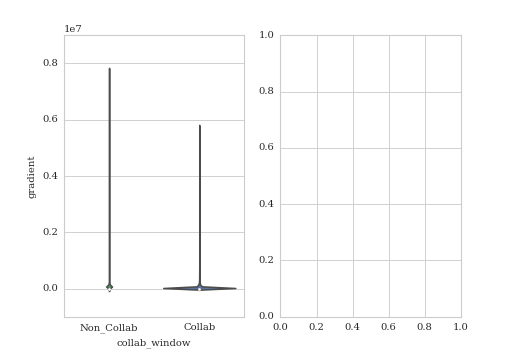

KeyboardInterrupt: 

In [144]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ax=ax1, inner='box')
sns.barplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ci=99,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views')
ax2.set_ylabel('mean(Views)')
fig.suptitle('Video view-count')
fig.tight_layout()
fig.subplots_adjust(top=0.86)

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ax=ax1, inner='box')
sns.barplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ci=99,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views %')
ax2.set_ylabel('mean(Views %)')
fig.suptitle('Video view-count %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)

<IPython.core.display.Javascript object>


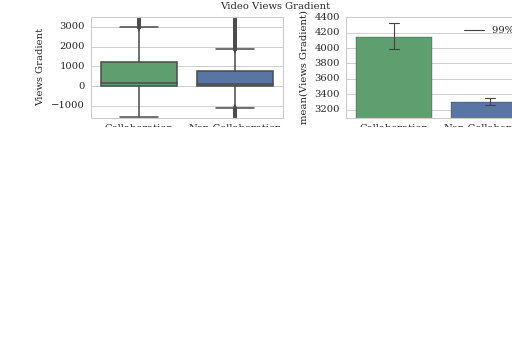

<IPython.core.display.Javascript object>


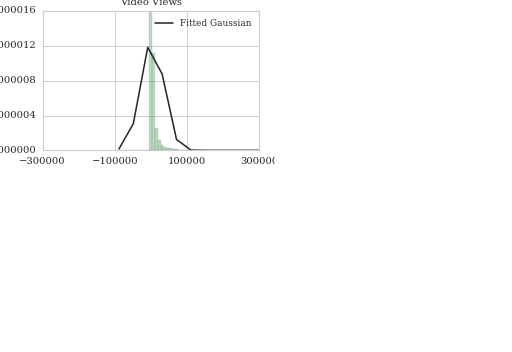

Normal-dist-test: NormaltestResult(statistic=13192493.868126784, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=609040441102.5, pvalue=0.0) 
p*2: 0.0
Wilcoxon rank-sum-test: RanksumsResult(statistic=67.132698369255181, pvalue=0.0) 
p*2: 0.0
Non_Collabs:
count    3.815349e+06
mean     3.305907e+03
std      3.059019e+04
min     -8.462700e+04
25%      1.300000e+01
50%      1.040000e+02
75%      7.620000e+02
max      7.837219e+06
Name: gradient, dtype: float64

Collabs:
count    2.973160e+05
mean     4.144535e+03
std      3.616439e+04
min     -3.096500e+04
25%      1.900000e+01
50%      1.580000e+02
75%      1.212000e+03
max      5.809283e+06
Name: gradient, dtype: float64


In [274]:
# Boxplot viewcount gradient for collab videos 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Gradient')
ax2.set_ylabel('mean(Views Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video Views Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-1600.0, 3500.0])
ax2.set_ylim([3100.0, 4400.0])
save_plot('collab_video_views_box_ci.pdf', fig, 2*s_width, 0.75*s_height)

# test, norm fitting
test = df_video_history_collabs_test[df_video_history_collabs_test["gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['gradient'])

fig = plt.figure()
ax = sns.distplot(test['gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["$\mu=${0:.2g}, $\sigma=${1:.2f}".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Video Views')
ax.set_ylim([0.0, 1.5e-05])
ax.set_xlim([-260000.0, 260000.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_video_views_norm_fit.pdf', fig, s_width, s_height)
print 'Normal-dist-test:', normaltest(test['gradient'])

collabs_grads = test[test.collab_window == 'Collab']['gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


print 'Non_Collabs:'
print df_video_history_collabs_test[df_video_history_collabs_test.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs_test[df_video_history_collabs_test.collab_window=='Collab']['gradient'].describe()

<IPython.core.display.Javascript object>


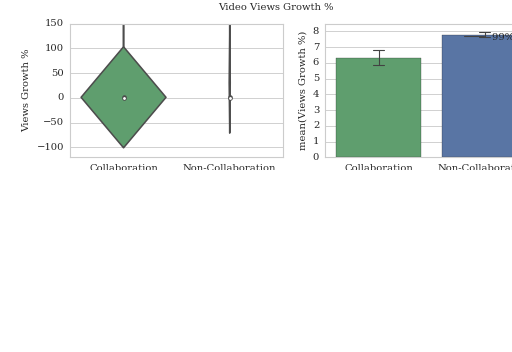

<IPython.core.display.Javascript object>


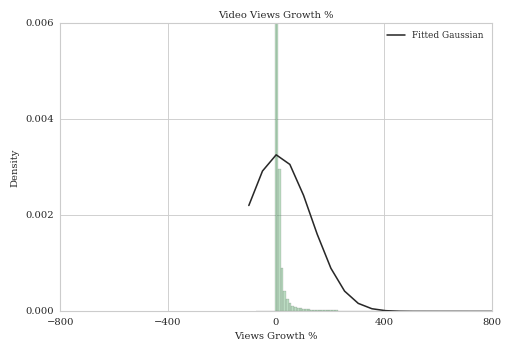

Normal-dist-test: NormaltestResult(statistic=12255295.288119387, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=559694078142.5, pvalue=3.085456597251137e-33) 
p*2: 6.1709131945e-33
Wilcoxon rank-sum-test: RanksumsResult(statistic=-12.009439135899697, pvalue=3.1698755695281311e-33) 
p*2: 6.33975113906e-33
count    297316.000000
mean          6.310792
std         109.123101
min         -83.098592
25%           0.104556
50%           0.319975
75%           0.952141
max        9961.585366
Name: p_gradient, dtype: float64
count    3.815349e+06
mean     7.796696e+00
std      1.230656e+02
min     -5.923076e+01
25%      1.008007e-01
50%      3.407290e-01
75%      1.078746e+00
max      9.978182e+03
Name: p_gradient, dtype: float64
0.319975005511
0.340729001585


In [181]:
# Boxplot view count percental gradient for collab videos 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Growth %')
ax2.set_ylabel('mean(Views Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video Views Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-120.0, 150.0])
ax2.set_ylim([0.0, 8.5])
save_plot('collab_video_views_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_history_collabs_test[df_video_history_collabs_test["p_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["$\mu=${0:.2g}, $\sigma=${1:.2f}".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views Growth %')
ax.set_ylabel('Density')
plt.title('Video Views Growth %')
ax.set_ylim([0.0, 0.006])
ax.set_xlim([-700.0, 700.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
#save_plot('collab_video_views_norm_fit.pdf', fig, s_width, s_height)
print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

print test[test.collab_window == 'Collab']['p_gradient'].describe()
print test[test.collab_window == 'Non_Collab']['p_gradient'].describe()

print test[test.collab_window == 'Collab']['p_gradient'].median()
print test[test.collab_window == 'Non_Collab']['p_gradient'].median()

In [ ]:
# get for all videos in df_videos_collabs the max popaurlty statiscs vlaue of the 12 days data


df_videos_collabs['12day_viewmax'] = np.nan
df_videos_collabs['12day_likemax'] = np.nan
df_videos_collabs['12day_dislikemax'] = np.nan
df_videos_collabs['12day_commentmax'] = np.nan

for index, group in video_history_collab_group:
    #print group.head()
    df_videos_collabs.ix[index, '12day_viewmax'] = group[(group.crawlTimestamp <= group.iloc[0, 5] + timedelta(days=12))]['viewCount'].max()
    df_videos_collabs.ix[index, '12day_likemax'] = group[(group.crawlTimestamp <= group.iloc[0, 5] + timedelta(days=12))]['likeCount'].max()
    df_videos_collabs.ix[index, '12day_dislikemax'] = group[(group.crawlTimestamp <= group.iloc[0, 5] + timedelta(days=12))]['dislikeCount'].max()
    df_videos_collabs.ix[index, '12day_commentmax'] = group[(group.crawlTimestamp <= group.iloc[0, 5] + timedelta(days=12))]['commentCount'].max()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [148]:
print len(df_videos_collabs)
print df_videos_collabs['12day_viewmax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_viewmax'].isnull()])
print df_videos_collabs['12day_likemax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_likemax'].isnull()])
print df_videos_collabs['12day_dislikemax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_dislikemax'].isnull()])
print df_videos_collabs['12day_commentmax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_commentmax'].isnull()])

81486
count    6.764800e+04
mean     1.728373e+05
std      5.010130e+05
min      1.000000e+00
25%      4.940000e+03
50%      2.772850e+04
75%      1.266482e+05
max      1.706475e+07
Name: 12day_viewmax, dtype: float64
13838
count    6.764800e+04
mean     9.233844e+03
std      3.951147e+04
min      0.000000e+00
25%      1.510000e+02
50%      9.080000e+02
75%      4.824250e+03
max      1.956001e+06
Name: 12day_likemax, dtype: float64
13838
count     67648.000000
mean        307.286084
std        3184.341032
min           0.000000
25%           6.000000
50%          32.000000
75%         149.000000
max      639683.000000
Name: 12day_dislikemax, dtype: float64
13838
count    6.764800e+04
mean     1.201489e+03
std      2.144439e+04
min      0.000000e+00
25%      2.900000e+01
50%      1.520000e+02
75%      6.570000e+02
max      5.423785e+06
Name: 12day_commentmax, dtype: float64
13838


In [149]:
# save to file
df_videos_collabs.to_csv(DIR+r'/df_video_collabs_stats.txt', sep=str('\t'), encoding='utf-8')
#df_videos_collabs = pa.read_csv(DIR+r'/df_video_collabs_stats.txt', sep=str('\t'), encoding='utf-8')
#df_videos_collabs=df_videos_collabs.set_index(['id'])
#df_videos_collabs.head()

4234


<IPython.core.display.Javascript object>


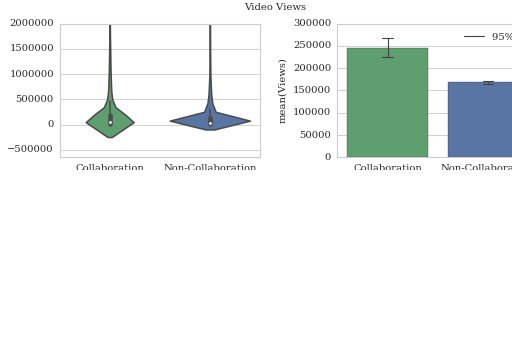

<IPython.core.display.Javascript object>


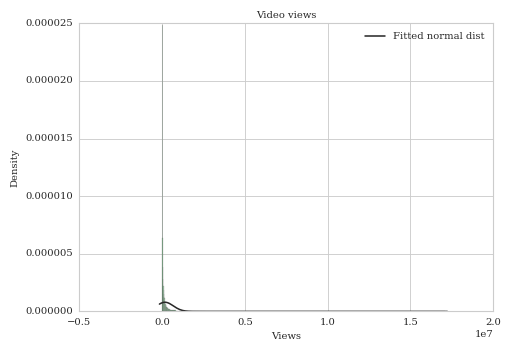

Normal-dist-test: NormaltestResult(statistic=101917.2419282568, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=147421662.0, pvalue=9.3143387005482232e-27) 
p*2: 1.86286774011e-26
Wilcoxon rank-sum-test: RanksumsResult(statistic=10.70821234960807, pvalue=9.3142992794214324e-27) 
p*2: 1.86285985588e-26


<IPython.core.display.Javascript object>


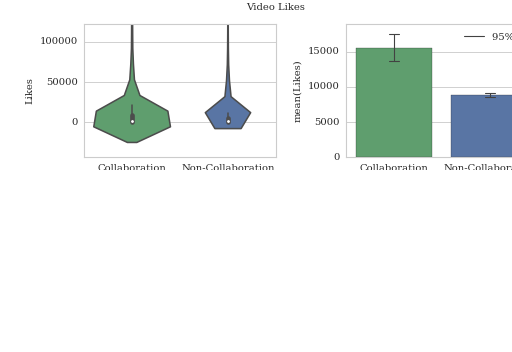

<IPython.core.display.Javascript object>


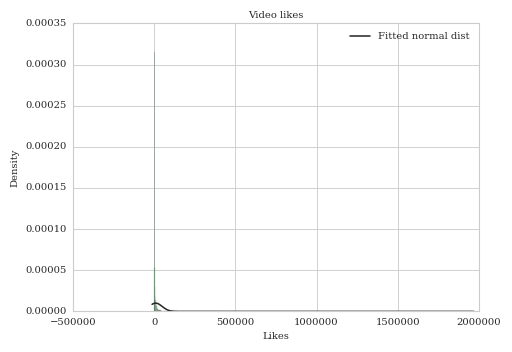

Normal-dist-test: NormaltestResult(statistic=140872.45728523246, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=153109791.5, pvalue=4.695549889606518e-53) 
p*2: 9.39109977921e-53
Wilcoxon rank-sum-test: RanksumsResult(statistic=15.331611690477786, pvalue=4.7017430583714563e-53) 
p*2: 9.40348611674e-53


<IPython.core.display.Javascript object>


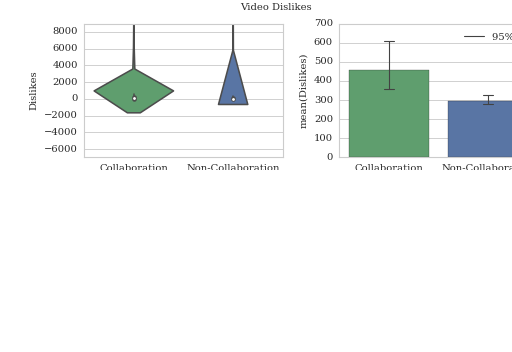

<IPython.core.display.Javascript object>


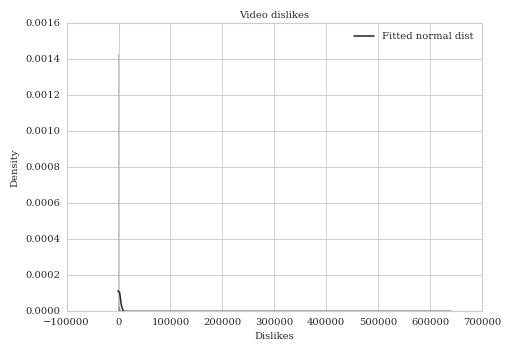

Normal-dist-test: NormaltestResult(statistic=294539.16440824792, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=148802470.5, pvalue=2.5642100414263072e-32) 
p*2: 5.12842008285e-32
Wilcoxon rank-sum-test: RanksumsResult(statistic=11.830554783754005, pvalue=2.7134241110749869e-32) 
p*2: 5.42684822215e-32


<IPython.core.display.Javascript object>


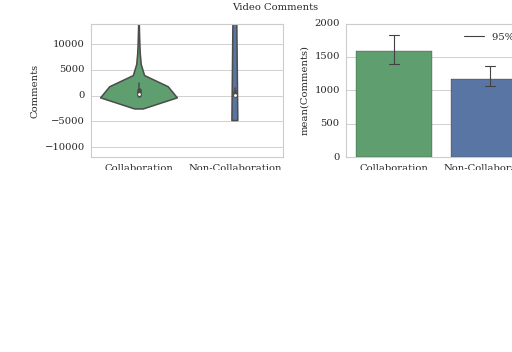

<IPython.core.display.Javascript object>


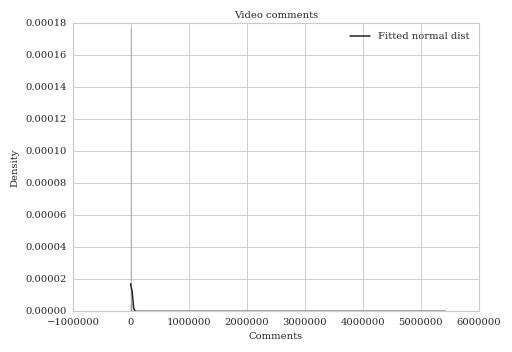

Normal-dist-test: NormaltestResult(statistic=348146.15695784736, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=149519667.0, pvalue=2.1979927274611458e-35) 
p*2: 4.39598545492e-35
Wilcoxon rank-sum-test: RanksumsResult(statistic=12.413503154633055, pvalue=2.2077730402106398e-35) 
p*2: 4.41554608042e-35


In [182]:
# all viewcounts complete
# for all channel mixed not very good/accurate, as channel have different popularities

from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

print len(df_videos_collabs[df_videos_collabs['collab_window']=='Collab'])

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="12day_viewmax", data=df_videos_collabs, ax=ax1, inner='box',order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="12day_viewmax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2,order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views')
ax2.set_ylabel('mean(Views)')
fig.suptitle('Video Views')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-650000.0, 2000000.0])
save_plot('collab_video_12day_view_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_viewmax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_viewmax'])

fig = plt.figure()
ax = sns.distplot(test['12day_viewmax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Video views')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_viewmax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_viewmax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_viewmax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="12day_likemax", data=df_videos_collabs, ax=ax1, inner='box',order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="12day_likemax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2,order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Likes')
ax2.set_ylabel('mean(Likes)')
fig.suptitle('Video Likes')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-44000.0, 123000.0])
ax2.set_ylim([0.0, 19000.0])
save_plot('collab_video_12day_like_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_likemax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_likemax'])

fig = plt.figure()
ax = sns.distplot(test['12day_likemax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Likes')
ax.set_ylabel('Density')
plt.title('Video likes')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_likemax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_likemax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_likemax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="12day_dislikemax", data=df_videos_collabs, ax=ax1, inner='box',order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="12day_dislikemax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2,order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Dislikes')
ax2.set_ylabel('mean(Dislikes)')
fig.suptitle('Video Dislikes')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-7000.0, 9000.0])
save_plot('collab_video_12day_dislike_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_dislikemax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_dislikemax'])

fig = plt.figure()
ax = sns.distplot(test['12day_dislikemax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Dislikes')
ax.set_ylabel('Density')
plt.title('Video dislikes')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_dislikemax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_dislikemax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_dislikemax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="12day_commentmax", data=df_videos_collabs, ax=ax1, inner='box',order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="12day_commentmax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2,order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(95)], loc=0)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Comments')
ax2.set_ylabel('mean(Comments)')
fig.suptitle('Video Comments')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-12000.0, 14000.0])
save_plot('collab_video_12day_comment_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_commentmax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_commentmax'])

fig = plt.figure()
ax = sns.distplot(test['12day_commentmax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Comments')
ax.set_ylabel('Density')
plt.title('Video comments')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_commentmax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_commentmax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_commentmax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

#print 'Collab:\n', df_videos_collabs.ix[df_videos_collabs.collab_window=='Collab',:].describe()
#print '\nNon_Collab:\n',df_videos_collabs.ix[df_videos_collabs.collab_window=='Non_Collab',:].describe()

<IPython.core.display.Javascript object>


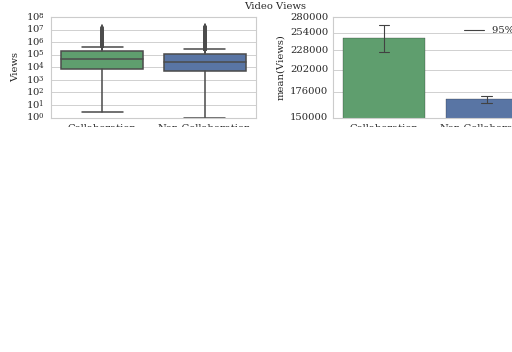

Collab:
count    4.234000e+03
mean     2.454193e+05
std      6.825585e+05
min      3.000000e+00
25%      6.969250e+03
50%      4.560500e+04
75%      1.874062e+05
max      1.407286e+07
Name: 12day_viewmax, dtype: float64

Non_Collab:
count    6.341400e+04
mean     1.679912e+05
std      4.861064e+05
min      1.000000e+00
25%      4.865000e+03
50%      2.675550e+04
75%      1.233325e+05
max      1.706475e+07
Name: 12day_viewmax, dtype: float64
Collab:
45605.0

Non_Collab:
26755.5


In [395]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="12day_viewmax", data=df_videos_collabs, ax=ax1,order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="12day_viewmax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2,order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views')
ax2.set_ylabel('mean(Views)')
fig.suptitle('Video Views')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
#ax1.set_ylim([-12000.0, 500000.0])
ax2.set_ylim([150000.0, 280000.0])
ax1.set_yscale('log')
ax2.set_yscale('log')
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
plt.tick_params(axis='y', which='minor')
ax2.yaxis.set_minor_formatter(FormatStrFormatter('%g'))
yloc = plt.MaxNLocator(5)
ylog = plt.LinearLocator(numticks=6)
ylog2 = plt.LinearLocator(numticks=6)
ax2.yaxis.set_major_locator(ylog)
ax2.yaxis.set_minor_locator(ylog2)
#ax2.set_yticks(ax2.get_yticks()[::2])
#ax2.set_yticklabels(ax2.get_yticklabels()[::8])
save_plot('collab_video_12day_view_box_ci_log.pdf', fig, 2*s_width, 0.75*s_height)

print 'Collab:\n', df_videos_collabs.ix[df_videos_collabs.collab_window=='Collab','12day_viewmax'].describe()
print '\nNon_Collab:\n',df_videos_collabs.ix[df_videos_collabs.collab_window=='Non_Collab','12day_viewmax'].describe()

print 'Collab:\n', df_videos_collabs.ix[df_videos_collabs.collab_window=='Collab','12day_viewmax'].median()
print '\nNon_Collab:\n',df_videos_collabs.ix[df_videos_collabs.collab_window=='Non_Collab','12day_viewmax'].median()

<IPython.core.display.Javascript object>


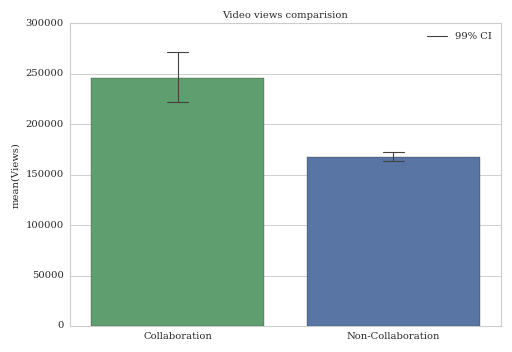

<IPython.core.display.Javascript object>


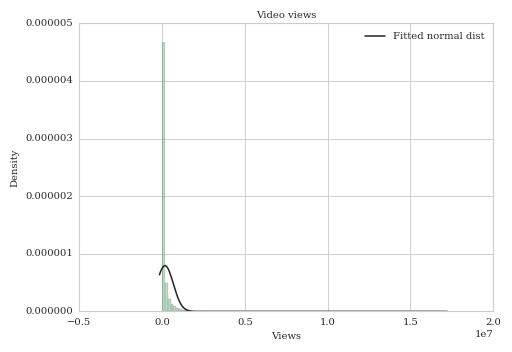

Normal-dist-test: NormaltestResult(statistic=101917.2419282568, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=147421662.0, pvalue=9.3143387005482232e-27)
Wilcoxon rank-sum-test: RanksumsResult(statistic=10.70821234960807, pvalue=9.3142992794214324e-27)


In [183]:
test = df_videos_collabs[df_videos_collabs["12day_viewmax"].notnull()]

# df_channel_history['viewCount_gradient']
fig = plt.figure()
ax = sns.barplot(x="collab_window", y="12day_viewmax", data=test, ci=99,errwidth=1., capsize=.1,order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax.set_xlabel('')
ax.set_ylabel('mean(Views)')
plt.title('Video views comparision')
plt.tight_layout()


#fig = plt.figure()
#ax = sns.distplot(test['6day_viewmax'], kde=False)
#ax.set_yscale('log')
#ax.set_xscale('log')

from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_viewmax'])

fig = plt.figure()
ax = sns.distplot(test['12day_viewmax'], fit=norm, kde=False, bins=100, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Video views')
plt.tight_layout()


print 'Normal-dist-test:', normaltest(test['12day_viewmax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_viewmax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_viewmax']

print '\nMann-Whitney-test:', mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
print 'Wilcoxon rank-sum-test:', ranksums(x=collabs_grads, y=non_collabs_grads)

In [260]:
print len(df_videos_collabs)
print len(df_videos_collabs.groupby(['channelID']))

81486
1589


In [265]:
print len(df_videos_collabs)
print len(df_videos_collabs.groupby(['channelID']))
df_video_channel_gr = df_videos_collabs.groupby(['channelID', 'collab_window'], as_index=False)


81486
1589
2705


In [264]:
# take every channel and get max/mean of collab, non_collab groups for views etc.
# create list with two entrys for every channel, collab, non_collab with mean value of above

# TODO check why number of channels with both types is so low

print len(df_videos_collabs)
print len(df_videos_collabs.groupby(['channelID']))
df_video_channel_mean = df_videos_collabs.groupby(['channelID', 'collab_window'], as_index=False).mean()
print len(df_video_channel_mean)
#print df_video_channel_mean.head()
video_channel_group = df_video_channel_mean.groupby('channelID')
print len(video_channel_group)

print df_videos_collabs['collab_window'].value_counts()
# calc growth of collab to non_collab per channel, only the two of same channel is comparable directly
df_collab_growth = []

#print video_channel_group.count()

for name, group in video_channel_group:
    if len(group) > 1:
        #print name
        #print group[['collab_window', '6day_viewmax']]
        c_v = group.iloc[0]['12day_viewmax']
        nc_v = group.iloc[1]['12day_viewmax']
        g = 100.0 * c_v / nc_v - 100
        #print g
        df_collab_growth.append((name, g))
    else:
        print name, group['collab_window']

df_collab_growth = pa.DataFrame(df_collab_growth)
print len(df_collab_growth)
#print df_collab_growth.head()
#df_collab_growth[1].mean()

 81486
1589
2705
1589
Non_Collab    77252
Collab         4234
Name: collab_window, dtype: int64
UC-PjJT0RVURj_L6D8D3WIww 12    Non_Collab
Name: collab_window, dtype: object
UC-SH7ZCar_m5Udkthm3j0Uw 15    Non_Collab
Name: collab_window, dtype: object
UC-SmWrDkILvnmfzE-43CdtA 18    Non_Collab
Name: collab_window, dtype: object
UC-V2ze2c4s7rV4neMd7ZS-w 21    Non_Collab
Name: collab_window, dtype: object
UC-q_5nCwFN3cUTW_wXlc7kg 34    Non_Collab
Name: collab_window, dtype: object
UC04ZT2MN2qF7tn2_JahRQRw 47    Non_Collab
Name: collab_window, dtype: object
UC0Juf8RX49w9_7FdvcjtNdA 50    Non_Collab
Name: collab_window, dtype: object
UC0PXqiud6dbwOAk8RvslgpQ 51    Non_Collab
Name: collab_window, dtype: object
UC0x8XBfvJoDzSqMzE56g2BQ 76    Non_Collab
Name: collab_window, dtype: object
UC19hDT4twVO-2553FiQmcXQ 83    Non_Collab
Name: collab_window, dtype: object
UC1C0x6WPqAavZoja1Qga-uw 86    Non_Collab
Name: collab_window, dtype: object
UC1H-sZk-cj-tDpfTCZ1f1YQ 89    Non_Collab
Name: collab_wi

<IPython.core.display.Javascript object>


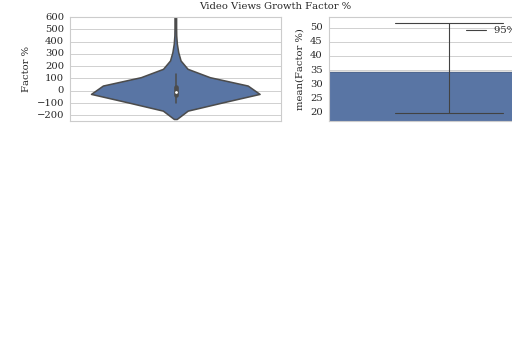

                 1
count  1108.000000
mean     34.322166
std     272.959967
min     -99.701347
25%     -37.295373
50%      -6.731477
75%      32.477690
max    6376.281237


In [259]:
# average difference, or growth between collab and noncollab, in%
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(data=df_collab_growth, ax=ax1,color=sns.color_palette()[1])
sns.barplot(data=df_collab_growth, ci=95,errwidth=1., capsize=.1, ax=ax2,color=sns.color_palette()[1])
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Factor %')
ax2.set_ylabel('mean(Factor %)')
fig.suptitle('Video Views Growth Factor %')
ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-250.0, 600.0])
ax2.set_ylim([15.0, 55.0])

for bar in ax2.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)
    
save_plot('collab_video_12day_growth_factor_box_ci_violin.pdf', fig, 2*s_width, 0.75*s_height)

print df_collab_growth.describe()

<IPython.core.display.Javascript object>


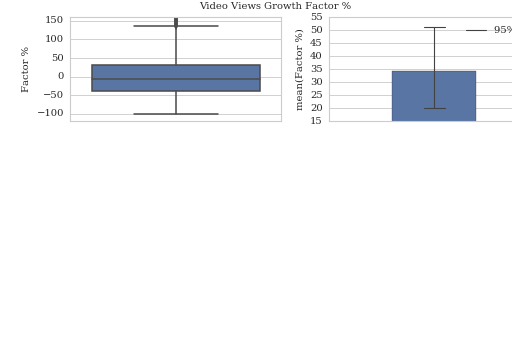

                 1
count  1108.000000
mean     34.322166
std     272.959967
min     -99.701347
25%     -37.295373
50%      -6.731477
75%      32.477690
max    6376.281237


In [244]:
# average difference, or growth between collab and noncollab, in%
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(data=df_collab_growth, ax=ax1,color=sns.color_palette()[1])
sns.barplot(data=df_collab_growth, ci=95,errwidth=1., capsize=.1, ax=ax2,color=sns.color_palette()[1])
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Factor %')
ax2.set_ylabel('mean(Factor %)')
fig.suptitle('Video Views Growth Factor %')
ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-120.0, 160.0])
ax2.set_ylim([15.0, 55.0])

for bar in ax2.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)
    
save_plot('collab_video_12day_growth_factor_box_ci.pdf', fig, 2*s_width, 0.75*s_height)

print df_collab_growth.describe()

In [154]:
df_channel = df_channel.set_index('id')
df_channel.head()

,topicIds,network,viewCount,subscriberCount,videoCount,commentCount,category,popularity
id,,,,,,,,
UC__Pj66OeDibNZNN__L913g,Music,None,3253022,23029,967,0,Entertainment,2
UC__PZLSRGtUQiTtvm3hPoEQ,Movies,BroadbandTV,310896,5878,144,0,Entertainment,1
UC__rmdgxs3ZF0zK_he7Tmig,Lifestyle,None,1291254,8146,294,121,How-to & Style,1
UC_-CxgsxX0tpnm24WO-797Q,Lifestyle,Maker Studios,625545,18990,67,101,How-to & Style,2
UC_1FUFB6TlGeGOyDI4ikkzg,Movies,BroadbandTV,89020205,106760,288,0,Entertainment,3


In [155]:
# use above data and split data into groups further to compare
# popualrity classes
# category class

# todo add popualrity class to channel and category
# read from file from channel notebook?
#

df_collab_growth_ext = df_collab_growth.copy()
df_collab_growth_ext.columns= ['id', 'growth']
df_collab_growth_ext['category'] = 'NaN'
df_collab_growth_ext['popularity'] = np.nan
df_collab_growth_ext.set_index('id', inplace=True)

for i, row in df_collab_growth_ext.iterrows():
    df_collab_growth_ext.loc[i, 'category'] = df_channel.loc[i, 'category']
    df_collab_growth_ext.loc[i, 'popularity'] = df_channel.loc[i, 'popularity']
    
df_collab_growth_ext.head()

,growth,category,popularity
id,,,
UC-4kjzuh4822B9yPSgpZQgA,10.813472,Entertainment,4.0
UC-63s9JLCZqIDlhXK6VHb7w,-89.944618,Entertainment,2.0
UC-A4oZF4AlOEdlyZWBCI0cQ,-4.630593,Entertainment,4.0
UC-CRXGRabkMD7x6V_Nk9F0A,-89.551831,Film & Animation,1.0
UC-NINtNMPM75eaqh07RCy_Q,93.463303,Education,3.0


In [156]:
# investigate groups from classes
df_collab_growth_category_groups = df_collab_growth_ext.groupby(by='category')
df_collab_growth_popularity_groups = df_collab_growth_ext.groupby(by='popularity')

print df_collab_growth_category_groups.count()
print df_collab_growth_popularity_groups.count()

                        growth  popularity
category                                  
Cars & Vehicles              7           7
Comedy                     128         129
Education                   40          40
Entertainment              387         387
Film & Animation            54          54
Gaming                      33          33
How-to & Style              91          93
Music                       60          61
News & Politics             12          12
Non-profits & Activism       2           2
People & Blogs             218         222
Pets & Animals               3           3
Science & Technology        34          34
Sports                      33          33
Travel & Events              6           6
            growth  category
popularity                  
0.0             25        25
1.0             78        78
2.0            278       282
3.0            532       536
4.0            186       186
5.0              8         8
6.0              1         1


In [157]:
test = df_collab_growth_category_groups.filter(lambda x: len(x) > 30)
test = test.groupby(by='category')

test_0 = test.get_group('Entertainment')
test_1 = test.get_group('People & Blogs')

<IPython.core.display.Javascript object>


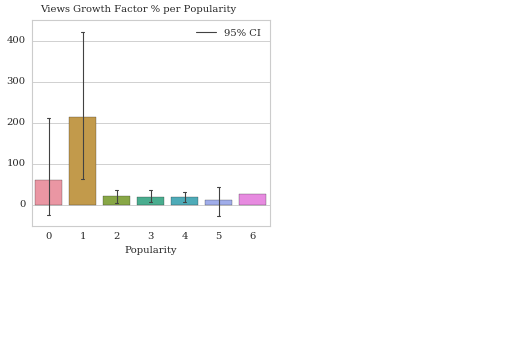

<IPython.core.display.Javascript object>


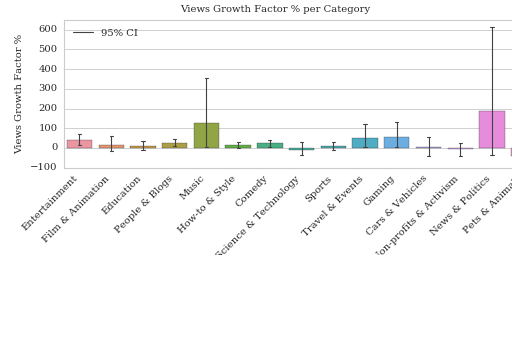

In [185]:
fig = plt.figure()
ax =sns.barplot(x='popularity', y='growth', data=df_collab_growth_ext, ci=95,errwidth=1., capsize=.1)
plt.legend(["{}% CI".format(95)])
ax.set_xlabel('Popularity')
ax.set_ylabel('Views Growth Factor %')
fig.suptitle('Views Growth Factor % per Popularity')
ax.set_xticklabels(range(7))
fig.tight_layout()
fig.subplots_adjust(top=0.92)
ax.set_ylim([-50.0, 450.0])
save_plot('collab_video_growth_factor_popularities.pdf', fig, s_width, 1.5*s_height)


fig = plt.figure()
ax = sns.barplot(x='category', y='growth', data=df_collab_growth_ext, ci=95,errwidth=1., capsize=.1)
plt.legend(["{}% CI".format(95)], loc=2)
ax.set_xlabel('Category')
ax.set_ylabel('Views Growth Factor %')
fig.suptitle('Views Growth Factor % per Category')
#ax1.set_xticklabels([''])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.set_ylim([-100.0, 650.0])
fig.tight_layout()
fig.subplots_adjust(top=0.92)

save_plot('collab_video_growth_factor_categories.pdf', fig, 2*s_width, 1.5*s_height)

<IPython.core.display.Javascript object>


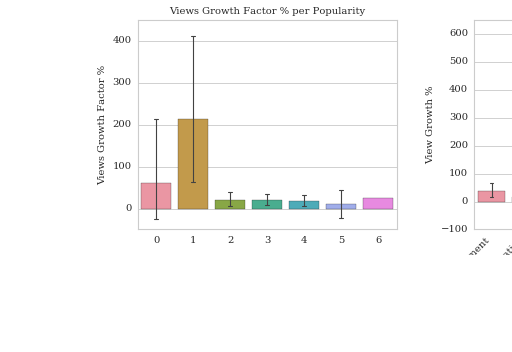

In [216]:
fig, (ax1, ax2) = plt.subplots(ncols=2, gridspec_kw = {'width_ratios':[1, 2]})

sns.barplot(x='popularity', y='growth', data=df_collab_growth_ext, ci=95,errwidth=1., capsize=.1, ax=ax1)
plt.legend(["{}% CI".format(95)])
#ax1.set_xlabel('Popularity')
ax1.xaxis.label.set_visible(False)
ax1.set_ylabel('Views Growth Factor %')
ax1.set_title('Views Growth Factor % per Popularity')
ax1.set_xticklabels(range(7))
ax1.set_ylim([-50.0, 450.0])
#fig.tight_layout()
sns.barplot(x='category', y='growth', data=df_collab_growth_ext, ci=95,errwidth=1., capsize=.1, ax=ax2)
#plt.legend(["{}% CI".format(95)], loc=2)
#ax2.set_xlabel('Category')
ax2.xaxis.label.set_visible(False)
ax2.set_ylabel('Views Growth Factor %')
ax2.set_title('Views Growth Factor % per Category')
#ax1.set_xticklabels([''])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), ha='right')
ax2.set_ylim([-100.0, 650.0])

fig.subplots_adjust(top=0.92)
#fig.tight_layout()
save_plot('collab_video_growth_factor_combined.pdf', fig, 4*s_width, 1.5*s_height)

<IPython.core.display.Javascript object>


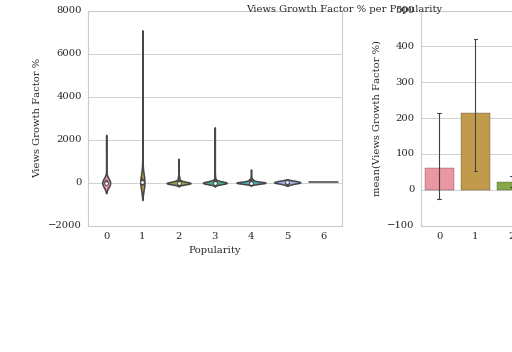

In [186]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x='popularity', y='growth', data=df_collab_growth_ext, ax=ax1)
sns.barplot(x='popularity', y='growth', data=df_collab_growth_ext, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('Popularity')
ax2.set_xlabel('Popularity')
ax1.set_ylabel('Views Growth Factor %')
ax2.set_ylabel('mean(Views Growth Factor %)')
fig.suptitle('Views Growth Factor % per Popularity')
#ax1.set_xticklabels([''])
#ax2.set_xticklabels([''])
ax1.set_xticklabels(range(7))
ax2.set_xticklabels(range(7))
fig.tight_layout()
#fig.subplots_adjust(top=0.86)
#ax1.set_ylim([-250.0, 800.0])
save_plot('collab_video_growth_factor_popularities_violin_bar.pdf', fig, 2.5*s_width, 1.5*s_height)

<IPython.core.display.Javascript object>


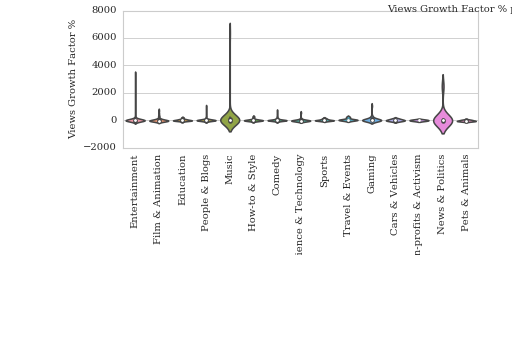

In [187]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x='category', y='growth', data=df_collab_growth_ext, ax=ax1,scale='width')
sns.barplot(x='category', y='growth', data=df_collab_growth_ext, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)])
#ax1.set_xlabel('')
#ax2.set_xlabel('')
ax1.set_ylabel('Views Growth Factor %')
ax2.set_ylabel('mean(Views Growth Factor %)')
fig.suptitle('Views Growth Factor % per Category')
#ax1.set_xticklabels([''])
#ax2.set_xticklabels([''])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
fig.tight_layout()
#fig.subplots_adjust(top=0.86)
#ax1.set_ylim([-250.0, 800.0])
save_plot('collab_video_growth_factor_categories_violin_bar.pdf', fig, 3.5*s_width, 1.5*s_height)

In [171]:
# make plots for views etc. x days after collab
# mark history data with x day after
print df_video_history_collabs['crawlTimestamp'].dtype
df_video_history_collabs.head()

datetime64[ns]


,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp,gradient,p_gradient,collab_window,day_after
id,,,,,,,,,,
1,qBZKeIbNDcE,9.0,0,1,0,2016-12-28 03:03:22,NaN,NaN,Non_Collab,-1
2,2A6NSm9aSVQ,139.0,5,14,2,2016-12-28 03:03:23,NaN,NaN,Non_Collab,-1
7,H_PpwvS8hA8,127.0,5,9,0,2016-12-28 03:04:08,NaN,NaN,Non_Collab,-1
9,lsN0rGSfXWw,122.0,4,37,0,2016-12-28 03:04:36,NaN,NaN,Non_Collab,-1
18,Azqy_VVj1PI,47536.0,2072,13325,60,2016-12-29 00:06:15,NaN,NaN,Non_Collab,-1


In [173]:
df_video_history_collabs['day_after'] = -1

cnt=0

for name, group in video_history_collab_group:
    
    if df_videos_collabs.ix[name, 'collab_window'] == 'Collab':
        date = group.iloc[0, 5]
        df_video_history_collabs.ix[group.index, 'day_after']  = group['crawlTimestamp'].apply(lambda x: (x-date).days)

df_video_history_collabs.head()

,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp,gradient,p_gradient,collab_window,day_after
id,,,,,,,,,,
1,qBZKeIbNDcE,9.0,0,1,0,2016-12-28 03:03:22,NaN,NaN,Non_Collab,-1
2,2A6NSm9aSVQ,139.0,5,14,2,2016-12-28 03:03:23,NaN,NaN,Non_Collab,-1
7,H_PpwvS8hA8,127.0,5,9,0,2016-12-28 03:04:08,NaN,NaN,Non_Collab,-1
9,lsN0rGSfXWw,122.0,4,37,0,2016-12-28 03:04:36,NaN,NaN,Non_Collab,-1
18,Azqy_VVj1PI,47536.0,2072,13325,60,2016-12-29 00:06:15,NaN,NaN,Non_Collab,-1


In [203]:
df_video_history_collabs_test = df_video_history_collabs[(df_video_history_collabs.day_after < 6)]
df_video_history_collabs_test = df_video_history_collabs_test[(df_video_history_collabs_test.p_gradient < 10000)]
print df_video_history_collabs.day_after.unique()
print df_video_history_collabs_test.day_after.unique()


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117]
[-1  1  2  3  4  5  0]


<IPython.core.display.Javascript object>


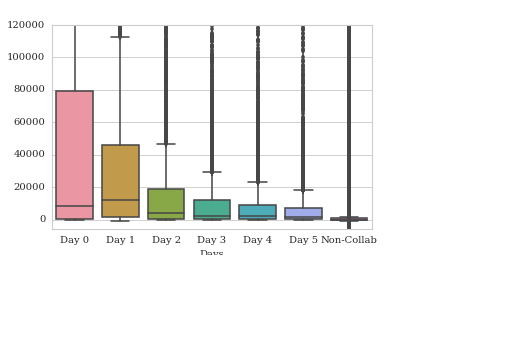

In [275]:
fig = plt.figure()
ax = sns.boxplot(x=df_video_history_collabs_test["day_after"], y=df_video_history_collabs_test["gradient"], order=[0, 1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
ax.set_ylim([-6000.0, 120000.0])
save_plot('collab_video_6days_sep_views_box_s_zero.pdf', fig, 1.5*s_width, 1.5*s_height)

<IPython.core.display.Javascript object>


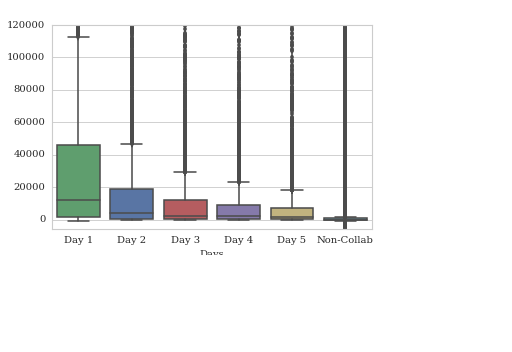

<IPython.core.display.Javascript object>


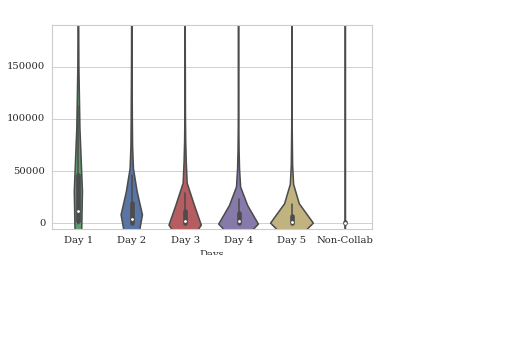

<IPython.core.display.Javascript object>


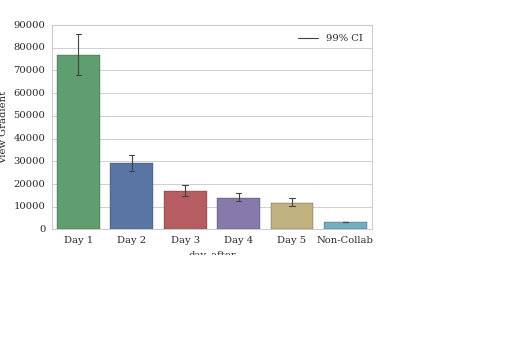

<IPython.core.display.Javascript object>


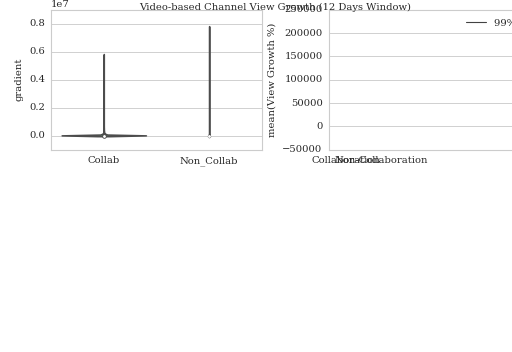

Non_Collabs:
count    3.815970e+06
mean     3.328708e+03
std      3.080674e+04
min     -8.462700e+04
25%      1.300000e+01
50%      1.040000e+02
75%      7.630000e+02
max      7.837219e+06
Name: gradient, dtype: float64

Collabs:
count    2.973410e+05
mean     4.159084e+03
std      3.633765e+04
min     -3.096500e+04
25%      1.900000e+01
50%      1.580000e+02
75%      1.212000e+03
max      5.809283e+06
Name: gradient, dtype: float64


In [204]:
fig = plt.figure()
ax = sns.boxplot(x=df_video_history_collabs_test["day_after"], y=df_video_history_collabs_test["gradient"], order=[1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
ax.set_ylim([-6000.0, 120000.0])
save_plot('collab_video_6days_sep_views_box_s.pdf', fig, 1.5*s_width, 1.5*s_height)

fig = plt.figure()
ax = sns.violinplot(x=df_video_history_collabs_test["day_after"], y=df_video_history_collabs_test["gradient"], order=[1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
ax.set_ylim([-6000.0, 190000.0])
save_plot('collab_video_6days_sep_views_box_violin_s.pdf', fig, 1.5*s_width, 1.5*s_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_ylabel('View Gradient')
ax2.set_ylabel('mean(View Gradient)')
save_plot('collab_video_6days_sep_views_ci_s.pdf', fig, 1.5*s_width, 1.5*s_height)

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ax=ax1, order=['Collab', 'Non_Collab'])
ax1 = sns.barplot(x="collab_window", y="gradient", data=df_video_history_collabs_test,ax=ax2, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])

plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Gradient')
ax2.set_ylabel('mean(View Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Growth (12 Days Window)')
fig.subplots_adjust(top=0.91)
fig.tight_layout()
ax1.set_ylim([-50000.0, 250000.0])
save_plot('collab_video_6days_sep_views_box_ci_violin.pdf', fig, 2*s_width, s_height)

print 'Non_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['gradient'].describe()



In [202]:
len(df_video_history_collabs_test[df_video_history_collabs_test.p_gradient > 10000])

645

<IPython.core.display.Javascript object>


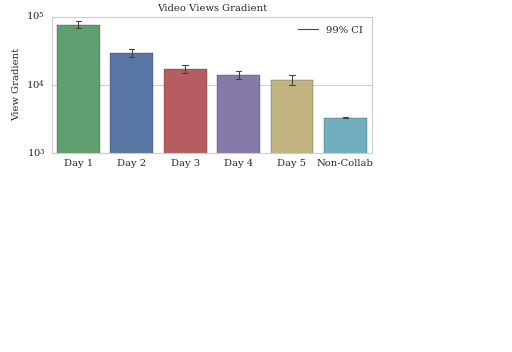

<IPython.core.display.Javascript object>


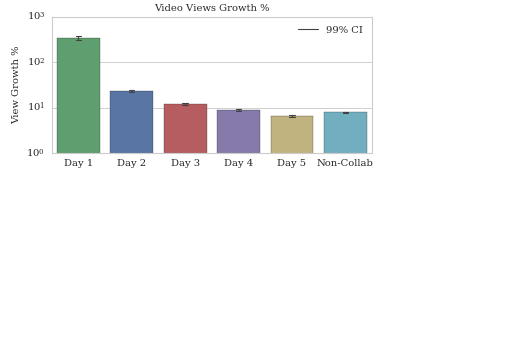

In [258]:
fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_ylabel('View Gradient')
#ax1.set_ylim([-20.0, 750.0])
ax1.xaxis.label.set_visible(False)
ax1.set_yscale('log')
plt.title('Video Views Gradient')
save_plot('collab_video_6days_sep_views_ci_s.pdf', fig, 1.5*s_width, s_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_ylabel('View Growth %')
ax1.xaxis.label.set_visible(False)
ax1.set_yscale('log')
plt.title('Video Views Growth %')
#ax.set_ylim([-20.0, 750.0])
save_plot('collab_video_6days_sep_views_ci_perc_s.pdf', fig, 1.5*s_width, s_height)

<IPython.core.display.Javascript object>


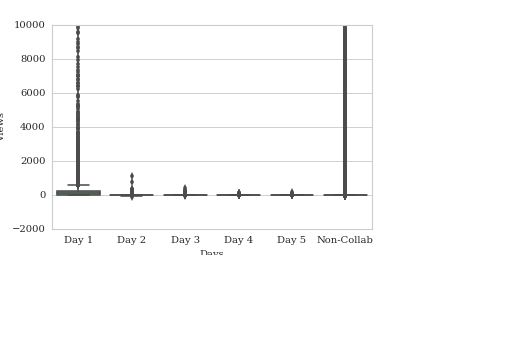

<IPython.core.display.Javascript object>


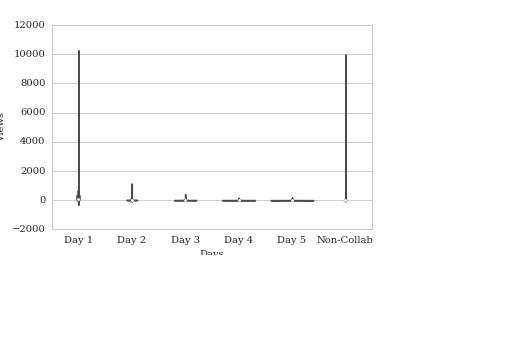

<IPython.core.display.Javascript object>


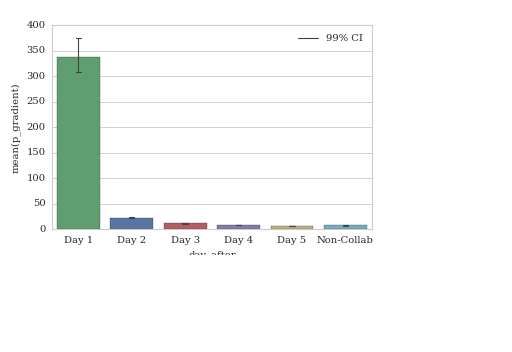

<IPython.core.display.Javascript object>


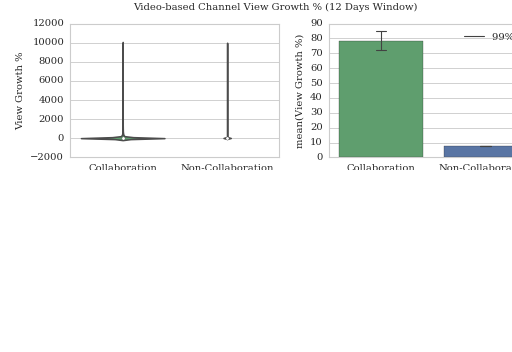

Non_Collabs:
count    3.815970e+06
mean     5.027533e+01
std      3.373144e+04
min     -5.923076e+01
25%      1.008216e-01
50%      3.408586e-01
75%      1.079559e+00
max      5.090080e+07
Name: p_gradient, dtype: float64

Collabs:
count    2.973410e+05
mean     6.125236e+02
std      3.291674e+05
min     -8.309859e+01
25%      1.045746e-01
50%      3.200044e-01
75%      9.523810e-01
max      1.794914e+08
Name: p_gradient, dtype: float64


In [206]:
fig = plt.figure()
ax = sns.boxplot(x=df_video_history_collabs_test["day_after"], y=df_video_history_collabs_test["p_gradient"], order=[1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
#ax.set_ylim([-20.0, 750.0])
save_plot('collab_video_6days_sep_views_box_perc_s.pdf', fig, 1.5*s_width, 1.5*s_height)

fig = plt.figure()
ax = sns.violinplot(x=df_video_history_collabs_test["day_after"], y=df_video_history_collabs_test["p_gradient"], order=[1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
#ax.set_ylim([-20.0, 750.0])
save_plot('collab_video_6days_sep_views_box_perc_violin_s.pdf', fig, 1.5*s_width, 1.5*s_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
save_plot('collab_video_6days_sep_views_ci_perc_s.pdf', fig, 1.5*s_width, 1.5*s_height)

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth %')
ax2.set_ylabel('mean(View Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Growth % (12 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
#ax1.set_ylim([-400.0, 1000.0])
save_plot('collab_video_6days_sep_views_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

print 'Non_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['p_gradient'].describe()

